### 라이브러리 모음

In [1]:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import sys, os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
sn.set()

import matplotlib.font_manager as fm
fl = fm.FontProperties(fname ="C:\Windows\Fonts\malgun.ttf").get_name()
plt.rc('font',family=fl)

from patsy import dmatrices
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

from mnist import load_mnist
from PIL import Image
import pickle

from collections import OrderedDict


### 활성화 함수 

In [2]:
import numpy as np


def sigmoid(x):
    return 1 / ( 1 + np.exp(-x))

def softmax(x):
    if x.ndim == 2: # x 크기는 2 
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # softmax 값이 너무 클때를 방지 # 오버플로우 
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error( y,t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size : # t.szie 와 y.size 는 값이 같아야 함
        t = t.argmax(axis=1)
            
    batch_size = y.shape[0]
    return -np.sum(np.log ( y[ np.arange(batch_size) , t ]+1e-7 ) )/ batch_size
    
##############################################################################################        

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x): # x 는 인풋값 
        self.mask = (x <= 0)# 0 보다 작으면 
        out = x.copy() # x를 그대로 아웃
        out[self.mask] = 0 # 0 보다 작으면 0 으로 아웃

        return out

    def backward(self, dout): # dout 은 미분의 곱, 미분의 토탈 
        dout[self.mask] = 0
        dx = dout

        return dx        
        
##############################################################################################  
        
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x): # x 를 시그모이드 적용후 바로 아웃 
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout): # dout 은 z->y 에서의 y 이다.
        dx = dout * (1.0 - self.out) * self.out

        return dx

##############################################################################################  

class Affine:
    def __init__(self, W, b): # Y = np.dot(X,W)+B 부분, 입력값 과 weight 값 두개 가 필요
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None # transpose 안한 x shape
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape # x.shape [ 행 , 열 ]
        x = x.reshape(x.shape[0], -1) # x[행, 열]
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx
    
##############################################################################################  

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력  y 의 순전파값
        self.t = None    # 정답 레이블(원-핫 인코딩 형태) /  0 또는 1,  실제값
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size # 배치사이즈로 나누기 = 평균으로 나눔 
            # dx 는 t 사이즈 - y 사이즈 서로간의 차이의 평균 즉, dx = 미분값 
            
        else: # y 의 값이 0 또는 1 둘다 아닐경우 ( 에러방지)
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

### 매개변수 클래스 

In [3]:
class SGD:
    def __init__ (self, lr = 0.01):
        self.lr = lr 
        
    def update ( self , params , grads ):
        for key in params.key():
            params[key] -= lr*grads[key] # W  = W - n * dw 
            
#################################################################################################           
            
class Momentum : 
    
    def __init__ ( self, lr = 0.01 , momentum = 0.9 ):
        self.lr = lr
        self.momentum = momentum
        self.v = None 
        
    def update ( self , params , grads):
        
        if self.v in None:   # 만약 v 가 없다면 0으로 채우라 
            self.v = {}
            
            for key , val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key , val in params.items():
                self.v[key] = self.momentum* self.v[key] - self.lr * grads[key] # W = alpha * V  - n * dw 
                params[key] += self.v[key]
                
#################################################################################################                  
                
class AdaGard : 
    
    def __init__ (self, lr = 0.01):
        self.lr = lr
        self.h = None # h 생성 
        
    def update ( self, params , grads ):
        
        if self.h is None :  # h가 만약 없다면 0 으로 채우기 
            self.h = {}
            
            for key , val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self. lr* grads[key] / (np.sqrt ( self.h[key] ) + 1e-7)  ### 업데이트 구간 
            
#################################################################################################  
            
class RMSprop : 
    
    def __init__ (self, lr = 0.01  , decay_rate = 0.99 ):
        self.lr = lr
        self.decay_rate = decay_rate # beta 
        self.h = None # h 생성 
        
    def update ( self, params , grads ):
        
        if self.h is None :  # h가 만약 없다면 0 으로 채우기 
            self.h = {}
            
            for key , val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            
            self.h[key] *= self.decay_rate 
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            
            params[key] -= self. lr* grads[key] / (np.sqrt ( self.h[key] ) + 1e-7)  ### 업데이트 구간  

            
#################################################################################################  

class Adam : 
    
    def __init__( self , lr = 0.001 , beta1= 0.9 , beta2 = 0.999):
        self.lr = lr 
        self.beta1 = beta1 #  좌우 이동평균  # v = beta 1 + ( 1- beta1) * dw 
        self.beta2 = beta2 #  상하 이동평균  # w = beat2 + ( 1 - beat2 ) * dw**2
        self.iter = 0 
        self.m = None # 좌우 빠르게   # 스텝방향  # 모멘텀 # V
        self.v = None # 상하는 느리게 # 스텝사이즈 # RMSprop  # H
        
    def update ( self , params , grads):
        
        if self.m in None :
            self.m , self. v = {} , {}
            
            for key , val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
                
            self.iter += 1 
            # 업데이트 평균을 보정하기 위한 값 ( 초반엔 평균값이 없기 때문에 )
            # sqrt(1/h)
            lr_t = self.lr * np.sqrt( 1.0 - self.beta2 ** self.iter)/ (1.0 - self.beta1 **self.iter) # eta 대신 sqrt( 1/h )
            
        for key in params.key():
            
            # V = 1 - beta 1 * dw - Vdw 
            self.m[key] += ( 1- self.beta1) * ( grads[key] - self.m[key]) # 모멘텀 부분  # dw 에 대한 이동평균 
            # h = 1 - beta2  * dw - Sdw 
            self.v[key] += ( 1- self.beta2) * ( grads[key] **2 -  self.v[key]) #  RMSprom 부분 # dw**2 에 대한 이동평균 
            
            # W = W - eta * 모멘텀 / sqrt( RMSprop ) +  보정값 
            params[key] -= lr_t * self.m[key] / ( np.sqrt(self.v[key])  + 1e-7 ) # 업데이트 부분 

## 0. DNN 학습 무보정 값


```python 

network =MultiLayerNetExtend( input_size= 인풋레이어 뉴런 수 , hidden_size_list=[ 히든레이어 사이즈 , 히든레이어 뉴런 수 ] ,
                       output_size= 아웃풋 레이어 뉴런 수 ,activation=활성화 함수 ( sigmoid or relu ) ,
                       weight_init_std= 표준편차 지정 ( defalut 값 =0.01 ) ,
                       weight_decay_lambda= 가중치 감소 수치 (defalut 값 = 0 , L2 정규화 실행시 0.1  )
                       use_dropout = 드랍아웃 사용시 True / 사용 X False
                       dropout_ration = 드랍아웃 시 뉴런 제거 확률 
                       use_batchnorm = 배치 정규화 사용시 Ture / 사용 X False 

```

#### DNN 학습의 성능개선을 효과적으로 확인하기 위해 아래 와 같은 악 조건을 부여한다.
    
    0. 다층 신경망 클래스는 multi_layer_net_extend.py 모듈에서 불러온다.
    1. MNIST 에 맞게 input layer 와 out layer 는 각 각 784 , 10  으로 고정 
    2. 히든 레이어 수 , 뉴런 수는 = 2층 , 30 으로 조정 
    3  활성화 함수는 'relu' 사용 
    4. 매개변수 가중치 초기값은 'Xaiver' , 'He' 둘다 사용하지 않음 X 
    5. L2 정규화 ,  드랍아웃 , 배치 정규화 사용하지 않음 X 

    
    6.. 매개변수 갱신 , 출력은 
    탐색경로가 비효율적이고 학습속도만 빠른 확률적 경사하강법 SGD 방법 사용 
    # 개인 PC 과부화 방지를 위해 batch_size = 100 으로 고정한다.

In [35]:
from multi_layer_net_extend import *
from mnist import load_mnist


(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

# 신경망 구조 클래스 
network =MultiLayerNetExtend( input_size= 784 , hidden_size_list=[50,50,50] , output_size=10 ,
                       activation='relu' ,weight_init_std=0.01 ,weight_decay_lambda=0 , use_dropout= False,
                            dropout_ration=0 , use_batchnorm=False) 

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x1 = []
plt_y1 = []

print('0.  DNN 학습 무보정 값')

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    

    grad = network.gradient(x_batch, t_batch)
    
    # SGD 방식 사용 
    
    for key in ('W1','b1','W2','b2' , 'W3' ,'b3' ,'W4' , 'b4' ):
        network.params[key] -= learning_rate*grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x1.append(train_acc)
        plt_y1.append(test_acc)
        
        print('트레이닝 결과값=', train_acc.round(3), '테스트_결과값=',test_acc.round(3))


# 트레이닝_ 결과값 , 테스트_결과값 이 천천히 증가했다가 , 빠르게 증가하는 들쑥 날쑥의 형태를 보인다.

0.  DNN 학습 무보정 값
트레이닝 결과값= 0.099 테스트_결과값= 0.103
트레이닝 결과값= 0.112 테스트_결과값= 0.114
트레이닝 결과값= 0.112 테스트_결과값= 0.114
트레이닝 결과값= 0.112 테스트_결과값= 0.114


### 0. 코멘트

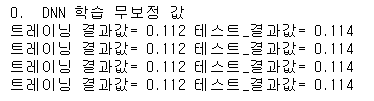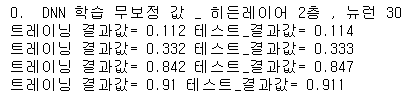
 
    - 정규화 , 가중치 초기값 , 드랍아웃 , 배치 정규화 미사용 
    - 속도에만 집중된 매개변수 갱신 SGD

    - 상단의 이유로 DNN 결과값은 91% 일치 하는 DNN 결과를 보여준다.
    - 특히나 가중치 표준편차를 0.01 로 지정하면
    - 히든레이어의 수 와 히든레이어 뉴런의 수가 많아질수록
    - 가중치 업데이트 될 수록 가중치 가  편향 되기 때문에 DNN 결과값이 10%에서 더 이상 개선되지 않는 결과를 보여준다.

## 1. He 초기값 , L2 정규화 사용시 DNN 학습 변화 

    1. 가중치 표준편차 Xavier , He 초기값, 
    - 많은 w 가 0 이 되어 모델 압축이 필요한 경우 L1 regularization , 그렇지 않은경우 L2 regularization 을 사용한다.
    - MNIST 신경망의 W 는 비교적 적음으로 다중신경망 클래스의 가중치 w 에서, L2 regularization 을 사용하여 DNN 학습을 개선한다.
    
    MultilayerNetExpend 클래스의 weight_init_std 인자를 'Xavier' 로 지정 시,
    가중치 업데이트 함수에서
$$\sqrt{\frac{1}{n(l-1)}}$$
    
    상단의 계산식이 가중치의 표준편차로 적용이 되고,
    
    weight_init_std 인자를 'He' 로 지정 시,
    
$$\sqrt{\frac{2}{n(l-1)}}$$

    상단의 계산식이 가중치의 표준편차로 적용이 되어
    클래스의 인자만으로 쉽게 가중치 표준편차를 변경할 수 있다.
    
```python
    
    def 가중치 업데이트(self, 가중치 표준편차 값):

        모든 레이어 list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = 가중치 표준편차 값. 임의로 지정할 수있지만 'He' 나 'Xavier' 로 지정하면 하단의 if문 실행
            if str(weight_init_std).lower() in ('relu', 'he'):
                # relu 또는 He 입력시 He 초기값 실행 
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                # sigmoid 또는 xaiver 입력시 Xavier 초기값 실행
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  
                
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

```
    
    
    2. L2 정규화 
    - 가중치 표준편차와 마찬가지로 MultilayerNetExtend 클래스의 weight_decay_lambda 인자를 지정하는 것으로 
    - 정규화를 적용시킬 수 있다. 
$$W \leftarrow W - \eta \frac{\partial L}{\partial W}+L2정규화부분$$ 
    
    - weight_decay_lambda 인자를 지정하는 것만으로도 
    - 하단의 업데이트 룰에 L2 정규화를 쉽게 적용 시킬 수 있다.

#### 수학식 부문
```python

        for idx in range(1, self.hidden_layer_num+2):
            grads[ 업데이트 룰 ] = layers[업데이트 dW] + self.L2 정규화  *.ayers[ 업데이트 W] 
            grads[ 업데이트 bias ] = self.layers[ 업데이트 db]

        return 활성화 함수를 적용하고 최종 업데이트 grad 로 저장
```  

    3.
    - 가중치 초기값 ( Xavier , He 둘다 적용 ) , L2 정규화 ( weight_decay_lambda = 0.01 ) 두가지를 적용하고 
    - 매개변수 ( optimazar ) 는 SGD 를 사용한 뒤 DNN 학습개선을 확인한다.

In [36]:
from multi_layer_net_extend import *
from mnist import load_mnist


(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

network =MultiLayerNetExtend( input_size= 784 , hidden_size_list=[50,50,50], output_size=10 ,
                       activation='relu' ,weight_init_std='He' ,weight_decay_lambda=0.01 )

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x1 = []
plt_y1 = []

print('1.  L2 정규화 + Xavier 초기값')

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    

    grad = network.gradient(x_batch, t_batch)
    
    # SGD 방식 사용 
    
    for key in ('W1','b1','W2','b2' , 'W3' ,'b3' ,'W4' , 'b4'):
        network.params[key] -= learning_rate*grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x1.append(train_acc)
        plt_y1.append(test_acc)
        
        print('트레이닝 결과값=', train_acc.round(3), '테스트_결과값=',test_acc.round(3))



1.  L2 정규화 + Xavier 초기값
트레이닝 결과값= 0.111 테스트_결과값= 0.111
트레이닝 결과값= 0.913 테스트_결과값= 0.914
트레이닝 결과값= 0.933 테스트_결과값= 0.933
트레이닝 결과값= 0.941 테스트_결과값= 0.94


## 1. 코멘트

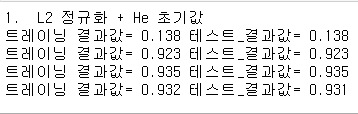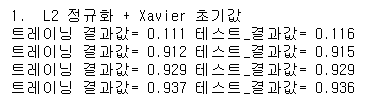


    - 가중치 초기값 , L2 정규화 2가지만 적용함에도 불구하고 
    - 다층 히든레이어 , 뉴런 수 가 많아져도 편차가 편향된 모습을 보이지 않고
    - 정답률 93% 대의 눈에 띄게 개선된 DNN 학습 상태을 볼 수 가 있다.

## 2. 매개변수 갱신을 통한 DNN 학습 개선 

## 2-1 모멘텀

    - 매개변수 갱신의 목표는 스텝방향 (v , 좌우 ) 또는 스텝사이즈 ( h , 상하 ) 를 
      조정하여 DNN 학습을 보다 빠르고 정확하게 개선하는 것이 목표이다.
    
    - 그 중에서도 모멘텀의 경우 스텝방향 (v,좌우) 를 지정하여 
    - 업데이트 룰인 
$$W \leftarrow W - \eta \frac{\partial L}{\partial W}$$ 에서

$$W \leftarrow W + v \leftarrow =\alpha v -\eta \frac{\partial L}{\partial W}$$ 

    - alpha ( 이동평균의 최초값이 없기때문에 0.99 로 보정 ) * ( 업데이트 마다 누적되는 이동평균 ( 스텝방향 ) 을 계산함으로    
    DNN 학습의 속도는 개선하지 않지만, 정확도를 향상 시키는 매개변수 갱신 방법 이다.

#### 모멘텀이 적용된 최종 업데이트 룰 / 수학식 부문 

```python 
    
    for key in ('W1','b1','W2','b2','W3','b3'): 
        v[key] = momentum(Alpha) * v[key](이동평균) - learning_rate(학습률) * grad[key] ( dw ) 
        network.params[key] += v[key]

```

#### momentum = 0.99 / Alpha 값이다. 이동평균의 최초값이 없기때문에 0.99로 보정한다.
#### v = None / 이동평균을 저장할 변수이다. 업데이트 갱신이 누적될때마다 이동평균을 누적할 변수이다.

In [37]:
from mnist import load_mnist

(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

# 다중신경망 클래스는 기존 오차역전파 만 사용한 클래스 로 사용한다. 

network =MultiLayerNetExtend( input_size= 784 , hidden_size_list=[50,50,50], output_size=10 ,
                       activation='relu' ,weight_init_std='relu' ,weight_decay_lambda=0 ) 
iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
momentum = 0.99 # Alpha - 이동평균의 최초값이 없기때문에 0.99로 보정
v = None # 스텝방향(이동평균) - 평균의 최초는 없기때문에 None 으로 지정 

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x5 = []
plt_y5 = []

print('2-1 모멘텀 DNN , 가중치 초기값 사용 L2 정규화 미사용' )
# 모멘텀 

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch) 
    
    if v is None: # 이동평균이 0 이라면 
        v = {}
        for key, val in network.params.items(): # 신경망구조에서 params ( 가중치 업데이트 ) 마다 평균값을 v에 입력 
            v[key] = np.zeros_like(val)
    for key in ('W1','b1','W2','b2','W3','b3'): # 업데이트 룰에 alpha 와 v 를 넣어줌으로써 DNN 학습에서 스텝방향 대입
        v[key] = momentum * v[key] - learning_rate * grad[key]
        network.params[key] += v[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x5.append(train_acc)
        plt_y5.append(test_acc)
        print('트레이닝 결과값=', train_acc.round(3), '테스트_결과값=',test_acc.round(3))

2-1 모멘텀 DNN , 가중치 초기값 사용 L2 정규화 미사용
트레이닝 결과값= 0.106 테스트_결과값= 0.109
트레이닝 결과값= 0.941 테스트_결과값= 0.938
트레이닝 결과값= 0.959 테스트_결과값= 0.953
트레이닝 결과값= 0.967 테스트_결과값= 0.959


## 2-1 모멘텀 코멘트

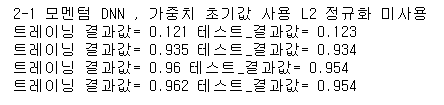

    - 스텝 방향 '만' 조절하였기 떄문에 학습 속도는 느리지만,
    - SGD 와 달리 트레이닝 결과값이 좋아졌다 나빠졌다 반복하지 않고 업데이트가 진행될 수록 일정하게 개선되는 모습을 보여준다.
    - 히든 레이어 와 뉴런 수 가 많기 때문에 가중치 초기값은 적용하였지만,
    - L2 정규화를 사용하지 않고 업데이트 룰에 스텝방향만 개선한 것 뿐인데도 
    - DNN 학습이 매우 개선된 모습을 보인다.

## RMSprop

    - 모멘텀과 마찬가지로 업데이트 룰의 이동평균을 대입하여 학습을 개선하는 방법이다.
    - 다만, 모멘텀 과 달리 스텝방향(좌우) 가 아닌 지수이동평균 을 사용해 스텝사이즈(상하) 만 조절하여 개선한다.
    - 즉, 학습 속도만 개선한 방법이다. 
    
#### decay_rate = beta 1 /  베타 값이다 모멘텀 의 alpha 와 마찬가지로 평균의 최초값이 없기때문에 보정해주는 최초값이다.
#### h = None / 지수이동평균 , 업데이트 갱신될때마다 지수이동평균의 값을 저장할 변수이다.

#### RMSprop 이 적용된 최종 업데이트 룰 / 수학식 부문 

```python 
    
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4','W5','b5'):
        h[key] += decay_rate # 베타 값 
        h[key] += (1 - decay_rate) * grads[key] * grads[key] # 1- 베타  * 업데이트 편미분 값들 , 계속해서 누적해서 h 에 저장
        network.params[key] -= learning_rate * grads[key] / (np.sqrt(h[key]) + 1e-7) # 업데이트 룰 부분 / h[key[] = 지수이동평균 

```

In [38]:
from mnist import load_mnist

(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

# 속도를 체감하기 위해 히든레이어 수 와 뉴런 수를 2배로 늘림 
network =MultiLayerNetExtend( input_size= 784 , hidden_size_list=[100,100,100,100], output_size=10 ,
                       activation='relu' ,weight_init_std='He' ,weight_decay_lambda = 0 ) 
iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
decay_rate = 0.99 # 베타 값
h = None # 지수이동평균 

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x5 = []
plt_y5 = []

print('2-2 RMRprop , 가중치 초기값 사용 , L2 정규화 미사용')

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch) 
    
    if h is None:
        h = {}
        for key, val in network.params.items():
            h[key] = np.zeros_like(val)
            
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4','W5','b5'):
        h[key] += decay_rate # 베타 값 
        h[key] += (1 - decay_rate) * grads[key] * grads[key] # 1- 베타  * 업데이트 편미분 값들 , 계속해서 누적해서 h 에 저장
        network.params[key] -= learning_rate * grads[key] / (np.sqrt(h[key]) + 1e-7) # 업데이트 룰 부분 / h[key[] = 지수이동평균 
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x5.append(train_acc)
        plt_y5.append(test_acc)
        print('트레이닝 결과값=', train_acc.round(3), '테스트_결과값=',test_acc.round(3))

2-2 RMRprop , 가중치 초기값 사용 , L2 정규화 미사용
트레이닝 결과값= 0.067 테스트_결과값= 0.069
트레이닝 결과값= 0.399 테스트_결과값= 0.417
트레이닝 결과값= 0.525 테스트_결과값= 0.533
트레이닝 결과값= 0.593 테스트_결과값= 0.599


## 2-2 RMSprop 코멘트


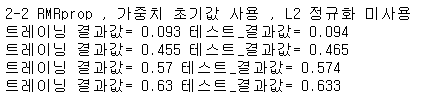


    - 히든레이어 수 와 뉴런 수 를 두배로 늘렸음에도 불구하고 모멘텀 과 비슷한 학습속도를 보여준다.
    - 다만 속도에만 치중된 업데이트 룰이기 때문에 DNN 정확도는 5~60% 대로 정확도는 매우 떨어지는 결과를 나타낸다.

## 2-3 Adam

    - 상단의 모멘텀( 스텝방향 )  과 RMSprop ( 스텝사이즈 ) 를 동시에 고려하는 기법.
#### beta1  =모멘텀 의 Alpha 변수 
#### m  = 이동평균 , 스텝방향 (좌우) 조절하는 변수     
   
$$v \leftarrow \alpha v + \frac{\partial L}{\partial W}$$    
#### beta2 = RMSprop 의 Beta 변수 
#### v = 지수이동평균 , 스텝사이즈(상하) 조절하는 변수
$$h \leftarrow \beta h + (1-\beta)\frac{\partial L}{\partial W}\odot \frac{\partial L}{\partial W} $$

    - 상단의 모멘텀 ,RMSprop 의 스텝방향, 스텝사이즈 를 모두 
    - 업데이트 룰에 적용함으로 써 DNN 의 상하좌우 학습을 개선하는 방법 
    
#### Adam 업데이트 룰 /  W = W - eta * 모멘텀 / sqrt( RMSprop ) +  보정값
$$W \leftarrow W - \eta \sqrt{\frac{1}{h}}v$$

    - v 는 모멘텀 , h 는 RMSprop
    
#### Adam 이 적용된 최종 업데이트 룰 / 수학식 부문 

```python 
    
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4'):
        m[key] += (1 - beta1) * (grads[key] - m[key])\
        v[key] += (1 - beta2) * (grads[key]**2 - v[key])
            
        network.params[key] -= lr_t * m[key] / (np.sqrt(v[key]) + 1e-7)

```   
   
## P.S 학습개선 효과를 극대화 하기위해 히든레이어 수 와 뉴런수를 4층, 300 으로 지정했습니다.
## 실행시 변경 하시는걸 권장 드립니다 !!

In [39]:
from mnist import load_mnist

(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

# RMSprop 과 마찬가지로  히든레이어 수 와 뉴런 수를 늘렸다.
network =MultiLayerNetExtend( input_size= 784 , hidden_size_list=[300,300,300], output_size=10 ,
                       activation='relu' ,weight_init_std='He' ,weight_decay_lambda = 0) 
iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
lr = 0.001
beta1 = 0.9 # 모멘텀의 Alpha 
beta2 = 0.999 # RMSprop 의 Beta  
iter_ = 0
m = None # 모멘텀 , 스텝방향을 담을 변수 
v = None # RMSprop , 스텝사이즈를 담을 변수 

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x5 = []
plt_y5 = []

print('2-3 Adam, 가중치 초기값 사용 , L2 정규화 미사용 ')

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch) 
    
# 이동평균 , 지수이동평균 의 누적 / 가중치 업데이트 될 때마다 m[key],v[key] 변수에 저장한다.
    if m is None:
        m , v = {} , {}
        for key, val in network.params.items():
            m[key] = np.zeros_like(val)
            v[key] = np.zeros_like(val)
            
    iter_ += 1
    lr_t = lr * np.sqrt( 1.0 - beta2**iter_) / (1.0 - beta1**iter_) 
            
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4'):
# 모멘텀 부분 # dw=grad[key] 에 대한 이동평균 갱신  / 수학식  V = (1-beta 1 ) * (dw - Vdw) #######################################
        m[key] += (1 - beta1) * (grads[key] - m[key])\
# RMSprop 부분 # dw 에 지수이동평균 갱신 / h = (1 - beta2) * (dw**2 - S dw)  ##################################################
        v[key] += (1 - beta2) * (grads[key]**2 - v[key])
            
# Adam 업데이트 룰  # W = W - eta * 모멘텀 / sqrt( RMSprop ) +  보정값 ##################################################
        network.params[key] -= lr_t * m[key] / (np.sqrt(v[key]) + 1e-7)
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x5.append(train_acc)
        plt_y5.append(test_acc)
        print('트레이닝 결과값=', train_acc.round(3), '테스트_결과값=',test_acc.round(3))

2-3 Adam, 가중치 초기값 사용 , L2 정규화 미사용 
트레이닝 결과값= 0.27 테스트_결과값= 0.266
트레이닝 결과값= 0.975 테스트_결과값= 0.969
트레이닝 결과값= 0.98 테스트_결과값= 0.969
트레이닝 결과값= 0.985 테스트_결과값= 0.975


## 2-3 Adam 코멘트

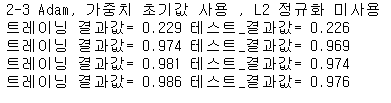

    - RMSprop 과 마찬가지로 학습속도가 매우 빨라졌다.
    - 특히나 DNN 학습 개선이 98% 나 되며
    - 지금까지 했던 학습 개선 중에서도 가장 베스트 의 학습 개선을 보여준다.

## 3-1 배치정규화

    - 배치 정규화는 학습 시의 미니배치를 한 단위로 정규화를 하는 것으로 분포의 평균이 0, 분산이 1이 되도록 정규화하는 것을 말한다.
    - 즉, 활성화 함수에서 레이어 -> 레이어 이동할 때 갱신되는 params[key] 의 분포를 고르게 퍼지게 하여
    - 1. 학습속도 , 2. 오버피팅 3. 가중치 초기값 의존성 문제 를 해결하는 방법이다.
    
    - MultilayerNetExtend 클래스 에서 use_batchnorm 인자를 =True 시 사용할 수 있는데
    - 배치정규화 인자를 활성화 하게 된다면 
    - 레이어 -> 레이어 이동할 때 활성화 함수에 
    - Gamma ( 분포 확대범위 ) , beta ( 이동평균 ) 을 추가하여
    - 활성화 함수의 params 값의 분포를 고르게 퍼지게 한다. 
    
```python
     if self.use_batchnorm 배치정규화가 True 라면:
                self.가중치['gamma 분포 확대범위' + str(idx)] = np.ones(히든레이어 수 - 1 만큼 실행)
                self.가중치['beta 이동평균' + str(idx)] = np.zeros( 히든레이어 수 - 1 만큼 실행)
                배치정규화 ( 감마, 베타 적용 된 활성화 함수 )  = 최종 활성화 함수 레이어 로 이동[activation]()


```

####  실행 
    - MultiLayerNetExtend 클래스 에서 use_batchnorm=True 지정한다.
    - Adam 매개변수 갱신으로 학습한다.

## P.S 히든레이어 수 와 뉴런 수를 변경하시는 것을 권장 드립니다 !!

In [40]:
from mnist import load_mnist

(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

# RMSprop 과 마찬가지로  히든레이어 수 와 뉴런 수를 늘렸다.
network =MultiLayerNetExtend( input_size= 784 , hidden_size_list=[300,300,300], output_size=10 ,
                       activation='relu' ,weight_init_std='He' ,weight_decay_lambda = 0 , use_batchnorm=True) 
iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
lr = 0.001
beta1 = 0.9 # 모멘텀의 Alpha 
beta2 = 0.999 # RMSprop 의 Beta  
iter_ = 0
m = None # 모멘텀 , 스텝방향을 담을 변수 
v = None # RMSprop , 스텝사이즈를 담을 변수 

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x5 = []
plt_y5 = []

print('3-1 배치정규화 사용 , Adam 사용')

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch) 
    
# 이동평균 , 지수이동평균 의 누적 / 가중치 업데이트 될 때마다 m[key],v[key] 변수에 저장한다.
    if m is None:
        m , v = {} , {}
        for key, val in network.params.items():
            m[key] = np.zeros_like(val)
            v[key] = np.zeros_like(val)
            
    iter_ += 1
    lr_t = lr * np.sqrt( 1.0 - beta2**iter_) / (1.0 - beta1**iter_) 
            
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4'):
# 모멘텀 부분 # dw=grad[key] 에 대한 이동평균 갱신  / 수학식  V = (1-beta 1 ) * (dw - Vdw) #######################################
        m[key] += (1 - beta1) * (grads[key] - m[key])\
# RMSprop 부분 # dw 에 지수이동평균 갱신 / h = (1 - beta2) * (dw**2 - S dw)  ##################################################
        v[key] += (1 - beta2) * (grads[key]**2 - v[key])
            
# Adam 업데이트 룰  # W = W - eta * 모멘텀 / sqrt( RMSprop ) +  보정값 ##################################################
        network.params[key] -= lr_t * m[key] / (np.sqrt(v[key]) + 1e-7)
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x5.append(train_acc)
        plt_y5.append(test_acc)
        print('트레이닝 결과값=', train_acc.round(3), '테스트_결과값=',test_acc.round(3))

3-1 배치정규화 사용 , Adam 사용
트레이닝 결과값= 0.14 테스트_결과값= 0.133
트레이닝 결과값= 0.977 테스트_결과값= 0.969
트레이닝 결과값= 0.987 테스트_결과값= 0.975
트레이닝 결과값= 0.989 테스트_결과값= 0.976


## 3-1 배치정규화 코멘트

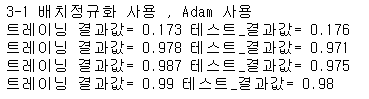

    - 속도는 개인 PC 역량으로 체감 되진 않았지만..
    - 이전에 가장 최적의 학습개선을 보여주었던 Adam 보다 더 높은 무려 99% 학습 정확도를 보여주었다.
    
### 거의 오차가 없는 가장 최적의 DNN 학습 상태를 확인할 수 있다.

## 3-2 드랍아웃

    - DNN 를 비롯한 CNN, 딥러닝 아키텍쳐들은 레이어, 뉴런 등의 데이터가 많아질 수록 샘플들이 선형관계를 이뤄
    과대적합 문제를 발생시키기 쉽다.
    - 드랍아웃은 이러한 수 많은 샘플들이 담긴 뉴런들을 일정 확률로 제거하는 방식으로 과대적합 문제를 해결하고 
    보다 정밀한 학습개선을 도와준다.
    
    - 다른 학습개선 과 마찬가지로 MultiLayerNetExtend 클래스의 use_dropout , dropout_ration 을 조정하여 Drop out 을 실행할 수 있다.
    
```python 

network = MultiLayerNetExtend(... , use_dropout=드랍아웃 사용시 True , dropout_ration= 뉴런을 제거할 확률(비율))

use_dropout = True 라면 
MultiLayerNetExtend 클래스 안에 외부 모듈 Dropout 클래스가 적용되어
dropout_ration 만큼 뉴런들을 제거한 후, self.layers 를 구성한다.

            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = 외부 모듈 (뉴런 제거할 확률(비율))

```


#### 드랍아웃의 효과를 극대화기 위해 학습데이터는 줄이는 대신, 히든 레이어 층 과 뉴런 수를 늘린다.
#### 가장 비효율적인 SGD 매개변수를 사용하여 드랍아웃의 T/F 를 비교한다.

In [41]:
from trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100,100,100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

iters_num = 200
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x1 = []
plt_y1 = []



# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.25 # 드랍아웃의 확률 = 뉴런 제거 확률  
# ====================================================

# 매개변수 SGD


for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch)
    

    for key in ('W1','b1','W2','b2' , 'W3' ,'b3' ,'W4' , 'b4' ,'W5' ,'b5' , 'W6' ,'b6'):
        network.params[key] -= learning_rate*grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x1.append(train_acc)
        plt_y1.append(test_acc)
        
        print('트레이닝 결과값=', train_acc.round(3), '테스트_결과값=',test_acc.round(3))
        
        
print('3-2 드랍아웃 , SGD ')



트레이닝 결과값= 0.13 테스트_결과값= 0.113
트레이닝 결과값= 0.14 테스트_결과값= 0.118
트레이닝 결과값= 0.15 테스트_결과값= 0.126
트레이닝 결과값= 0.187 테스트_결과값= 0.147
트레이닝 결과값= 0.223 테스트_결과값= 0.176
트레이닝 결과값= 0.27 테스트_결과값= 0.224
트레이닝 결과값= 0.347 테스트_결과값= 0.286
트레이닝 결과값= 0.347 테스트_결과값= 0.296
트레이닝 결과값= 0.367 테스트_결과값= 0.321
트레이닝 결과값= 0.377 테스트_결과값= 0.316
트레이닝 결과값= 0.413 테스트_결과값= 0.34
트레이닝 결과값= 0.427 테스트_결과값= 0.343
트레이닝 결과값= 0.457 테스트_결과값= 0.357
트레이닝 결과값= 0.407 테스트_결과값= 0.358
트레이닝 결과값= 0.427 테스트_결과값= 0.364
트레이닝 결과값= 0.443 테스트_결과값= 0.368
트레이닝 결과값= 0.44 테스트_결과값= 0.364
트레이닝 결과값= 0.473 테스트_결과값= 0.372
트레이닝 결과값= 0.507 테스트_결과값= 0.413
트레이닝 결과값= 0.46 테스트_결과값= 0.377
트레이닝 결과값= 0.487 테스트_결과값= 0.398
트레이닝 결과값= 0.497 테스트_결과값= 0.411
트레이닝 결과값= 0.513 테스트_결과값= 0.416
트레이닝 결과값= 0.53 테스트_결과값= 0.433
트레이닝 결과값= 0.537 테스트_결과값= 0.437
트레이닝 결과값= 0.543 테스트_결과값= 0.454
트레이닝 결과값= 0.553 테스트_결과값= 0.454
트레이닝 결과값= 0.547 테스트_결과값= 0.448
트레이닝 결과값= 0.557 테스트_결과값= 0.46
트레이닝 결과값= 0.567 테스트_결과값= 0.489
트레이닝 결과값= 0.56 테스트_결과값= 0.483
트레이닝 결과값= 0.567 테스트_결과값= 0.474
트레이닝 결과값= 0.573 테스

## 3-2 드랍아웃 코멘트 

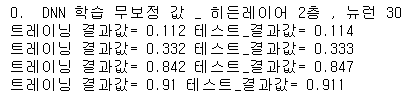

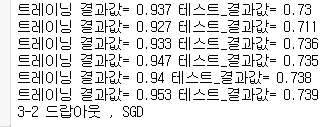


    - 6층 신경망 구조 + 대량의 뉴런 수 + 드랍아웃 True 한 것 뿐인데 
    - 2층 신경망 구조 + 30개의 뉴런 수  밖에 안되는 SGD 결과보다 오히려 높은 학습률을 볼 수 있다.

## 4. 결론 

- 0. 무보정 DNN 

    - 낮은 히든레이어 층 , 적은 뉴런의 수 만 활성화 함수가 정상적으로 작동되어 훈련이 가능하지만,
    - 데이터 셋의 규모, 히든레이어 층 , 뉴런 의 갯수 가 많아질 수록 가중치가 편향되어 학습훈련이 불가능해진다.
    - 학습 속도와 정확도가 매우 낮은 학습상황을 보여준다. 
    
    
- 1. 가중치 초기값 , L2 정규화 
    
    - 가중치 초기값을 가중치 업데이트에 대입하는 것으로 loss 함수가 정규분포 형태가 됨으로 써 
    - 대량의 데이터 셋 , 레이어 , 뉴런 으로도 충분히 학습이 가능하다는 것을 알 수 있다.
    
    - 가중치 초기값 + L2 정규화를 통해 loss 함수 의 분산을 줄여주고 과대적합 문제를 방지하여 DNN 학습률이 향상된 것을 알 수 있다.


- 2. 매개변수 갱신 (  모멘텀 , RMSprop , Adam )

    - 모멘텀 optimaizer 는 스텝방향(좌우) 를 지정하여 업데이트 속도는 느리지만 일정하게 학습이 개선되는 것을 볼 수 있다.
    - RMSprop 은 스텝 사이즈 (상하) 를 지정하여 업데이트 속도는 빠르지만 학습 개선에는 별로 개선 되지 않았다.
    
    - 그러나 Adam 은 스텝방향 , 스텝 사이즈 둘다 업데이트 룰에 적용함으로 써 
    - optimaizer 중에서 최고의 학습속도 그리고 최상의 학습개선 상태를 보여주었다.
 

- 3. 배치 정규화 , 드랍아웃 

    - 배치정규화 를 통해 활성화 함수의 분포를 확대 ( gamma ) , 이동 ( beta ) 값을 지정하는 것으로 
    - 활성화 함수의 가중치 분포를 고르게 하는것을 알 수 있었다. 
    
    - 특히나 배치정규화를 사용하고 Adam 을 통해 DNN 학습을 하였더니 모든 학습개선 중에서 최상의 학습 개선 상태를 보여 주었다.
    
    - 드랍 아웃을 통해 다층 레이어 ,  대량 의 뉴런 수 로도 충분히 학습이 가능하는 것을 보여 주었고
    - 특히나 외생변수로 레이어 와 뉴런을 조정하는 것 보다, 드랍아웃 을 사용하는 것이 
    - 더 좋은 학습 속도와 학습 상태를 보여주었다.


# 이상입니다. 감사합니다 15016033_안효빈